# Text Classification for Deep Vacurity

## Summary
## Load Data
## Exploratory analysis
## Data preparation
    3.1. Renaming the columns
    3.2. Dropping unwanted variable
    3.3. Selecting input variable
    3.4. Dropping missing values
    3.5. Balancing target categories for model input
## Text Filter
    4.1. Removing ponctuation and stopwords
    4.2. Lemmatizing and stemming
    4.3. Entity recognition and filtering
    4.4. Part-of-Speech analysis and filtering
    4.5. Analysing filtering results
## Text Parser
    5.1 Dropping missing entities and POS
    5.2 Counting and Vectorizing
    5.3 Grisearching Parameters
## Topic Modelling
    6.1 Generating Topics
    6.2 Grisearching Parameters
    6.3 Storing topics scores as variables
### Model Train and Cross-Validation
    7.1 Comparing models
    7.2 Evaluating winner model
    7.3 Confusion Matrix

In [43]:
"""
-*- coding: utf-8 -*- Created on Fri 21 2020
@author: Thiago Pinho
"""

from sklearn.model_selection import cross_val_score, train_test_split,\
    GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report,\
    plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
from plots import plot_term_scatter, plot_categories_distribution,\
    plot_wordcloud
warnings.simplefilter("ignore", DeprecationWarning)

For better code management, the constants used in this notebook will be listed bellow.

In [15]:
RELATIVE_PATH_TO_FOLDER = "./resources//data/"
DATA_FILENAME = "dic_ind_0_0"
VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "RISCO"
POSSIBLE_TEXT_VARIABLES = ["TXT"]

## 1. Load data
We'll have a look at the raw data and analyse it's structure.

In [26]:
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".json"
vacuity_df = pd.read_json(relative_path_file, orient='index')

vacuity_df.head()

,risco,txt
8960894,0,pregao presencial 32013 municipio prado torna ...
2276920,0,gerencia executiva natal extrato contrato 9020...
3120817,0,resultados julgamentos 0004 2005 nome empresa ...
3496330,0,rubens falcao silva neto secretaria estado art...
8259101,0,pregao presencial 192012 prefeitura municipal ...


## 2. Exploratory analysis
First we'll check datatypes and number of rows and columns

In [27]:
print("Data info:")
vacuity_df.info()

Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3814 entries, 8960894 to 12276651
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   risco   3814 non-null   int64 
 1   txt     3814 non-null   object
dtypes: int64(1), object(1)
memory usage: 89.4+ KB


## 3. Data preparation

### 3.1. Renaming the columns

Let's start uppercasing all column names and target variable values

In [28]:
vacuity_df['id'] = vacuity_df.index
vacuity_df.columns = map(lambda x: str(x).upper(), vacuity_df.columns)
vacuity_df[TARGET_VARIABLE] = vacuity_df[TARGET_VARIABLE].apply(lambda x: str(x))

vacuity_df.head()

,RISCO,TXT,ID
8960894,0,pregao presencial 32013 municipio prado torna ...,8960894
2276920,0,gerencia executiva natal extrato contrato 9020...,2276920
3120817,0,resultados julgamentos 0004 2005 nome empresa ...,3120817
3496330,0,rubens falcao silva neto secretaria estado art...,3496330
8259101,0,pregao presencial 192012 prefeitura municipal ...,8259101


In [30]:
raw_categories_df = plot_categories_distribution(vacuity_df,
                                                 'RISCO', 
                                                 'ID', 
                                                 'Initial distribution of Risco in Vacuity Dataset')

## 4. Text Filter

Before we train the model, it's necessary to create a bag of words by tokenizing each word, finding their lemmas and discarting some words that could mislead the model.

Let's take a first look at the raw text variable.

In [31]:
text_variable = 'TXT'
df_terms1 = plot_term_scatter(vacuity_df, text_variable, 'Top-100 terms in raw data')

### 4.1. Removing ponctuation and stopwords

As we can see, we have a lot of tokens from text variable being ponctuations or words that don't have by themselves much meaning. 

We're going to load a built-in stopwords list to remove these unnecessary tokens.

In [32]:
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese')))\
                               .union(set(['anos', 'ano', 'dia', 'dias']))
    
print("This is the stopword list: ", sorted(list(stopwords_set)))

This is the stopword list:  ['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'dias', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dã

### 4.2. Lemmatizing and stemming

In [36]:
data_df = vacuity_df

In [40]:
''' Not all variables are being undestood as strings so we have to force it'''
preprocessed_text_data = data_df[text_variable].to_list()
''' Create the pipeline 'sentencizer' component '''
sentencizer = NLP_SPACY.create_pipe('sentencizer')
try:
    ''' We then add the component to the pipeline if we hadn't done before '''
    NLP_SPACY.add_pipe(sentencizer, before='parser')
except ValueError:
    print("Pipe already present.")

print(NLP_SPACY.pipe_names)

tokenized_data = []
semantics_data = []
lemmatized_doc = []
normalized_doc = []
raw_doc = []
for row in preprocessed_text_data:
    doc = NLP_SPACY(row)
    preprocessed_doc = [token for token in doc if token.is_alpha and not token.norm_ in stopwords_set]
    tokenized_data.append(preprocessed_doc)
    raw_doc.append(" ".join([word.text for word in preprocessed_doc]))
    lemmatized_doc.append(" ".join([word.lemma_ for word in preprocessed_doc]))
    normalized_doc.append(" ".join([word.norm_ for word in preprocessed_doc]))

data_df['RAW_DOC'] = raw_doc
data_df['NORMALIZED_DOC'] = normalized_doc
data_df['LEMMATIZED_DOC'] = lemmatized_doc

data_df.head()

Pipe already present.
['tagger', 'sentencizer', 'parser', 'ner']


Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0/3814 [04:49<?, ?it/s]>
Traceback (most recent call last):
  File "/home/dev/anaconda3/envs/unb_deep_vacurity/lib/python3.6/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/dev/anaconda3/envs/unb_deep_vacurity/lib/python3.6/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0/3814 [02:33<?, ?it/s]>
Traceback (most recent call last):
  File "/home/dev/anaconda3/envs/unb_deep_vacurity/lib/python3.6/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/dev/anaconda3/envs/unb_deep_vacurity/lib/python3.6/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0

,RISCO,TXT,ID,RAW_DOC,NORMALIZED_DOC,LEMMATIZED_DOC
8960894,0,pregao presencial 32013 municipio prado torna ...,8960894,pregao presencial municipio prado torna public...,pregao presencial municipio prado torna public...,pregao presencial municipio prado tornar publi...
2276920,0,gerencia executiva natal extrato contrato 9020...,2276920,gerencia executiva natal extrato contrato proc...,gerencia executiva natal extrato contrato proc...,gerencia executivo natal extrato contratar pro...
3120817,0,resultados julgamentos 0004 2005 nome empresa ...,3120817,resultados julgamentos nome empresa nivel cons...,resultados julgamentos nome empresa nivel cons...,resultar julgamento nome empresar nivel constr...
3496330,0,rubens falcao silva neto secretaria estado art...,3496330,rubens falcao silva neto secretaria articulaca...,rubens falcao silva neto secretaria articulaca...,rubens falcao silvar neto secretariar articula...
8259101,0,pregao presencial 192012 prefeitura municipal ...,8259101,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...


In [41]:
'''Visual plotting of terms pre-processing'''
df_terms2 = plot_term_scatter(data_df, 'RAW_DOC', 'Top-100 terms of tokenized data without lemmatizaton')
df_terms3 = plot_term_scatter(data_df, 'NORMALIZED_DOC', 'Top-100 terms of normalized data with minor lemmatization')
df_terms4 = plot_term_scatter(data_df, 'LEMMATIZED_DOC', 'Top-100 terms of with full lemmatization')

### 4.3. Entity recognition and filtering

Some parts of speech may mislead the model associating classes to certain entities that are not really related to the categories.
The NER model (spacy portuguese) we are using uses the following labels:

| TYPE | DESCRIPTION |
|------|-------------------------------------------------------------------------------------------------------------------------------------------|
| PER | Named person or family. |
| LOC | Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains). |
| ORG | Named corporate, governmental, or other organizational entity. |
| MISC | Miscellaneous entities, e.g. events, nationalities, products or works of art. |

Let's take a look at all entities present in the text

In [44]:
entities_obs = []
for doc in tokenized_data:
    for token in doc:
        if token.ent_type_:
            entities_obs.append((token.text, token.ent_type_))

entities_df = pd.DataFrame(entities_obs, columns=['entity_text', 'entity_type'])
entities_df['id'] = entities_df.index
grouped_entities_df = (entities_df.groupby(['entity_text', 'entity_type']).count()
                                                                         .reset_index()
                                                                         .rename(columns={'id': 'count'})
                                                                         .sort_values('count', ascending=False)
                                                                         .head(100))
                
fig = px.treemap(grouped_entities_df, 
                 path=['entity_type', 'entity_text'], 
                 values='count', 
                 title='Top-50 entities present in text grouped by type')
fig.show()
entity_type_df = grouped_entities_df['entity_type'].value_counts().reset_index()

fig = px.pie(entity_type_df, values='entity_type', names='index', title='Entity type frequency')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [45]:
processed_tokenized_data = []
processed_doc_text = []
entities_obs = []
entity_unwanted_types = set(['PER', 'ORG'])

for doc in tokenized_data:
    entities_text = ""
    processed_doc = []
    for token in doc:
        if not token.ent_type_:
            processed_doc.append(token)
        elif not token.ent_type_ in entity_unwanted_types:
            processed_doc.append(token)
            entities_obs.append((token.text, token.ent_type_))
        
    processed_tokenized_data.append(processed_doc)
    processed_doc_text.append(" ".join([word.norm_ for word in processed_doc ]))

''' Processing text on entity level'''
data_df['PROCESSED_DOC'] = processed_doc_text
data_df.head()

,RISCO,TXT,ID,RAW_DOC,NORMALIZED_DOC,LEMMATIZED_DOC,PROCESSED_DOC
8960894,0,pregao presencial 32013 municipio prado torna ...,8960894,pregao presencial municipio prado torna public...,pregao presencial municipio prado torna public...,pregao presencial municipio prado tornar publi...,pregao presencial municipio prado torna public...
2276920,0,gerencia executiva natal extrato contrato 9020...,2276920,gerencia executiva natal extrato contrato proc...,gerencia executiva natal extrato contrato proc...,gerencia executivo natal extrato contratar pro...,gerencia executiva natal extrato contrato proc...
3120817,0,resultados julgamentos 0004 2005 nome empresa ...,3120817,resultados julgamentos nome empresa nivel cons...,resultados julgamentos nome empresa nivel cons...,resultar julgamento nome empresar nivel constr...,resultados julgamentos nome empresa nivel cons...
3496330,0,rubens falcao silva neto secretaria estado art...,3496330,rubens falcao silva neto secretaria articulaca...,rubens falcao silva neto secretaria articulaca...,rubens falcao silvar neto secretariar articula...,secretaria articulacao governamental
8259101,0,pregao presencial 192012 prefeitura municipal ...,8259101,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...


In [46]:
entities_df = pd.DataFrame(entities_obs, columns=['entity_text', 'entity_type'])
entities_df['id'] = entities_df.index
grouped_entities_df = (entities_df.groupby(['entity_text', 'entity_type']).count()
                                                                         .reset_index()
                                                                         .rename(columns={'id': 'count'})
                                                                         .sort_values('count', ascending=False)
                                                                         .head(100))
fig = px.treemap(grouped_entities_df, 
                 path=['entity_type', 'entity_text'], 
                 values='count', 
                 title='Top-50 entities present in text grouped by type after filtering')
fig.show()

entity_type_df = grouped_entities_df['entity_type'].value_counts().reset_index()
fig = px.pie(entity_type_df, values='entity_type', names='index', title='Entity type frequency after filtering')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 4.4 Part-of-Speech analysis and filtering
Let's take a look in the parts of speech presents in the dataset

In [47]:
token_obs = []
for doc in processed_tokenized_data:
    for token in doc:
        token_obs.append((token.norm_, token.pos_))

token_df = pd.DataFrame(token_obs)
token_df.columns = ['token', 'pos']
token_df['id'] = token_df.index

''' Plotting token grouped by POS treemap '''
grouped_token_df = (token_df.groupby(['token', 'pos']).count()
                                                     .reset_index()
                                                     .rename(columns={'id': 'count'})
                                                     .sort_values('count', ascending=False)
                                                     .head(100))

fig = px.treemap(grouped_token_df, 
                 path=['pos', 'token'], 
                 values='count', 
                 title='Top-100 tokens present in text grouped by Part-of-Speech')
fig.show()

''' Plotting POS bar chart '''
pos_df = token_df.groupby('pos').count().reset_index().rename(columns={'token':'count'})

fig = px.bar(pos_df, x='pos', y='count', text='count', title="Part-of-Speech type frequency")
fig.update_layout(xaxis_categoryorder = 'total descending')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

Here is a wordcloud showing a sample of not relevant words to the text classification that are present in our text variable.

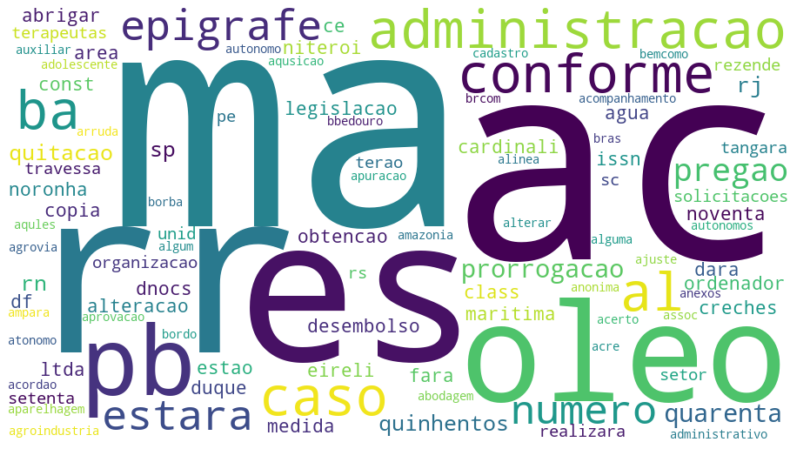

In [48]:
token_df['id'] = token_df.index
grouped_token_df = token_df.groupby(['token', 'pos']).count().reset_index().rename(columns={'id': 'count'})

plot_wordcloud(grouped_token_df[~grouped_token_df['pos'].isin(set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"]))]['token'])

In [49]:
allowed_pos_set = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

processed_doc = []
filtered_token_obs = []
for doc in processed_tokenized_data:
    doc_tokens = [word for word in doc if str(word.pos_) in allowed_pos_set]
    filtered_token_obs.append(doc_tokens)
    processed_doc.append(" ".join(token.norm_ for token in doc_tokens))

data_df['PROCESSED_DOC'] = processed_doc
data_df['TOKENS'] = filtered_token_obs
data_df.head()

,RISCO,TXT,ID,RAW_DOC,NORMALIZED_DOC,LEMMATIZED_DOC,PROCESSED_DOC,TOKENS
8960894,0,pregao presencial 32013 municipio prado torna ...,8960894,pregao presencial municipio prado torna public...,pregao presencial municipio prado torna public...,pregao presencial municipio prado tornar publi...,pregao presencial municipio prado torna public...,"[pregao, presencial, municipio, prado, torna, ..."
2276920,0,gerencia executiva natal extrato contrato 9020...,2276920,gerencia executiva natal extrato contrato proc...,gerencia executiva natal extrato contrato proc...,gerencia executivo natal extrato contratar pro...,gerencia executiva natal extrato contrato proc...,"[gerencia, executiva, natal, extrato, contrato..."
3120817,0,resultados julgamentos 0004 2005 nome empresa ...,3120817,resultados julgamentos nome empresa nivel cons...,resultados julgamentos nome empresa nivel cons...,resultar julgamento nome empresar nivel constr...,resultados julgamentos nome empresa nivel cons...,"[resultados, julgamentos, nome, empresa, nivel..."
3496330,0,rubens falcao silva neto secretaria estado art...,3496330,rubens falcao silva neto secretaria articulaca...,rubens falcao silva neto secretaria articulaca...,rubens falcao silvar neto secretariar articula...,secretaria articulacao governamental,"[secretaria, articulacao, governamental]"
8259101,0,pregao presencial 192012 prefeitura municipal ...,8259101,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,pregao presencial prefeitura municipal atraves...,"[pregao, presencial, prefeitura, municipal, at..."


In [50]:
space_pattern = r'\s\s+'
data_df['PROCESSED_DOC'] = data_df['PROCESSED_DOC'].str.replace(space_pattern, " ").str.strip()

In [51]:
token_obs = []
for doc in filtered_token_obs:
    for token in doc:
        token_obs.append((token.norm_, token.pos_))

token_df = pd.DataFrame(token_obs)
token_df.columns = ['token', 'pos']
token_df['id'] = token_df.index

''' Plotting token grouped by POS treemap '''
grouped_token_df = (token_df.groupby(['token', 'pos']).count()
                                                     .reset_index()
                                                     .rename(columns={'id': 'count'})
                                                     .sort_values('count', ascending=False)
                                                     .head(100))

fig = px.treemap(grouped_token_df, 
                 path=['pos', 'token'], 
                 values='count', 
                 title='Top-100 tokens present in text grouped by Part-of-Speech after filtering')
fig.show()

''' Plotting POS bar chart '''
pos_df = token_df.groupby('pos').count().reset_index().rename(columns={'token':'count'})

fig = px.bar(pos_df, x='pos', y='count', text='count', title="Part-of-Speech type frequency after filtering")
fig.update_layout(xaxis_categoryorder = 'total descending')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [55]:
category_tokens_obs_df = data_df.groupby(TARGET_VARIABLE)['TOKENS'].sum().reset_index()

category_tokens_df = category_tokens_obs_df.explode('TOKENS')
category_tokens_df.reset_index(drop=True, inplace=True)
category_tokens_df['ID'] = category_tokens_df.index

category_tokens_df['TOKENS'] = category_tokens_df['TOKENS'].map(lambda token: token.norm_)

grouped_category_tokens_df = (category_tokens_df.groupby([TARGET_VARIABLE, 'TOKENS']).count()
                                                                                   .reset_index()
                                                                                   .rename(columns={'ID': 'COUNT'})
                                                                                   .sort_values('COUNT', ascending=False))

sampled_category_tokens_df = pd.DataFrame()
for category in grouped_category_tokens_df[TARGET_VARIABLE].unique():
    sampled_category_tokens_df = sampled_category_tokens_df.append(
        grouped_category_tokens_df[grouped_category_tokens_df[TARGET_VARIABLE]  == category].nlargest(10, 'COUNT')
    )

fig = px.treemap(sampled_category_tokens_df, 
                 path=[TARGET_VARIABLE, 'TOKENS'], 
                 values='COUNT', 
                 title='Top-10 tokens present in each category')
fig.show()

In [57]:
processed_data_df = data_df
processed_data_df = processed_data_df.drop(columns=['TOKENS']).dropna()
print(processed_data_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3814 entries, 8960894 to 12276651
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RISCO           3814 non-null   object
 1   TXT             3814 non-null   object
 2   ID              3814 non-null   int64 
 3   RAW_DOC         3814 non-null   object
 4   NORMALIZED_DOC  3814 non-null   object
 5   LEMMATIZED_DOC  3814 non-null   object
 6   PROCESSED_DOC   3814 non-null   object
dtypes: int64(1), object(6)
memory usage: 238.4+ KB
None


### 5.2. Counting and Vectorizing

As our model works only with numerical data we need to convert the string tokens to numeric equivalents which are called features. This part is responsible to give weights to important tokens and remove weight for unwanted ones or those who can be misguiding.
Let's first instantiate the models used for this process. 
CountVectorizer generates weights relative to how many times a word or a combination or words(ngrams) appear no matter how big is the document.
While TfidfTransformer makes it proportional to the size of the document. The parm "use_idf" highlights the less
frequents ones because they can be more informative than other words that appear a lot.

In [58]:
''' Best parameter using GridSearch (CV score=0.535): 
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True,
'vect__max_df': 0.6000000000000001, 'vect__max_features': None, 'vect__min_df': 0.0007,
'vect__ngram_range': (1, 2)}
Those were obtained on the next code block.
'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    processed_data_df['PROCESSED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

In [59]:
term_codes = []
for code, value in enumerate(count_vectors.toarray()[0]):
    if value:
        term_codes.append(code)

frequency_values = []
for code, value in enumerate(frequency_vectors.toarray()[0]):
    if code in term_codes:
        frequency_values.append(str(round(value*100, 2))+"%")

terms = []
for code in term_codes:
    terms.append(count_vectorizer.get_feature_names()[code])

features_frequencies_df = pd.DataFrame({'Feature Name': terms, 'Feature Code': term_codes, 'Feature Percentual Frequency': frequency_values})
features_frequencies_df

,Feature Name,Feature Code,Feature Percentual Frequency
0,acordo,157,1.87%
1,administracao,322,1.71%
2,cidade,2174,1.75%
3,conhecimento,2849,1.77%
4,conhecimento licitantes,2858,3.27%
5,fica,6142,1.7%
6,fica revogado,6161,3.37%
7,informacoes,7324,1.41%
8,informacoes poderao,7342,2.28%
9,interessar,7603,2.66%


In [60]:
is_gridsearching = False
if is_gridsearching:
    search_count_vectorizer = CountVectorizer()
    search_tfidf_transformer = TfidfTransformer()
    clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')
    
    ''' Those are all the params values that will be tested.'''
    search_params = {
        'vect__min_df': np.arange(0, 0.001, 0.0003),
        'vect__max_df': np.arange(0.2, 0.9, 0.3),
        'vect__max_features': [None],
        'vect__ngram_range': [(1, 2), (1, 3), (2, 3)],
        'tfidf__norm': ['l2'],
        'tfidf__use_idf': [False, True],
        'tfidf__smooth_idf': [False],
        'tfidf__sublinear_tf' : [False, True]}
    
    search_pipeline = Pipeline([
        ('vect', search_count_vectorizer),
        ('tfidf', search_tfidf_transformer),
        ('clf', clf)
    ])

    gs = GridSearchCV(search_pipeline,
                      param_grid=search_params, cv=5)
    gs.fit(data_df['PROCESSED_DOC'].values, data_df[TARGET_VARIABLE])
    results = gs.cv_results_
    print(gs.best_params_)

## 7. Model Train and Cross-Validation

In [61]:
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

scores = cross_val_score(
    pipeline,
    processed_data_df['PROCESSED_DOC'],
    processed_data_df[TARGET_VARIABLE], cv=10)
print("Mean accuracy for pipeline: ", str(round(scores.mean()*100,2))+"%")

Mean accuracy for pipeline:  90.88%


### 7.2 Evaluating the winner model

In [62]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
     processed_data_df['PROCESSED_DOC'].to_list(),
    processed_data_df[TARGET_VARIABLE].to_list(),
    test_size=0.25, random_state=42)

''' First we need to instantiate some components again to avoid overfit'''
count_vectorizer = CountVectorizer(
    max_features=None, min_df=0.0007, max_df=0.6000000000000001, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf=True, sublinear_tf=True)
clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])

train1 = X_train
labelsTrain1 = y_train
test1 = X_test
labelsTest1 = y_test
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=processed_data_df[TARGET_VARIABLE].unique()))

accuracy: 0.9014675052410901
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       489
           1       0.87      0.94      0.90       465

    accuracy                           0.90       954
   macro avg       0.90      0.90      0.90       954
weighted avg       0.90      0.90      0.90       954



### 7.3 Confusion Matrix

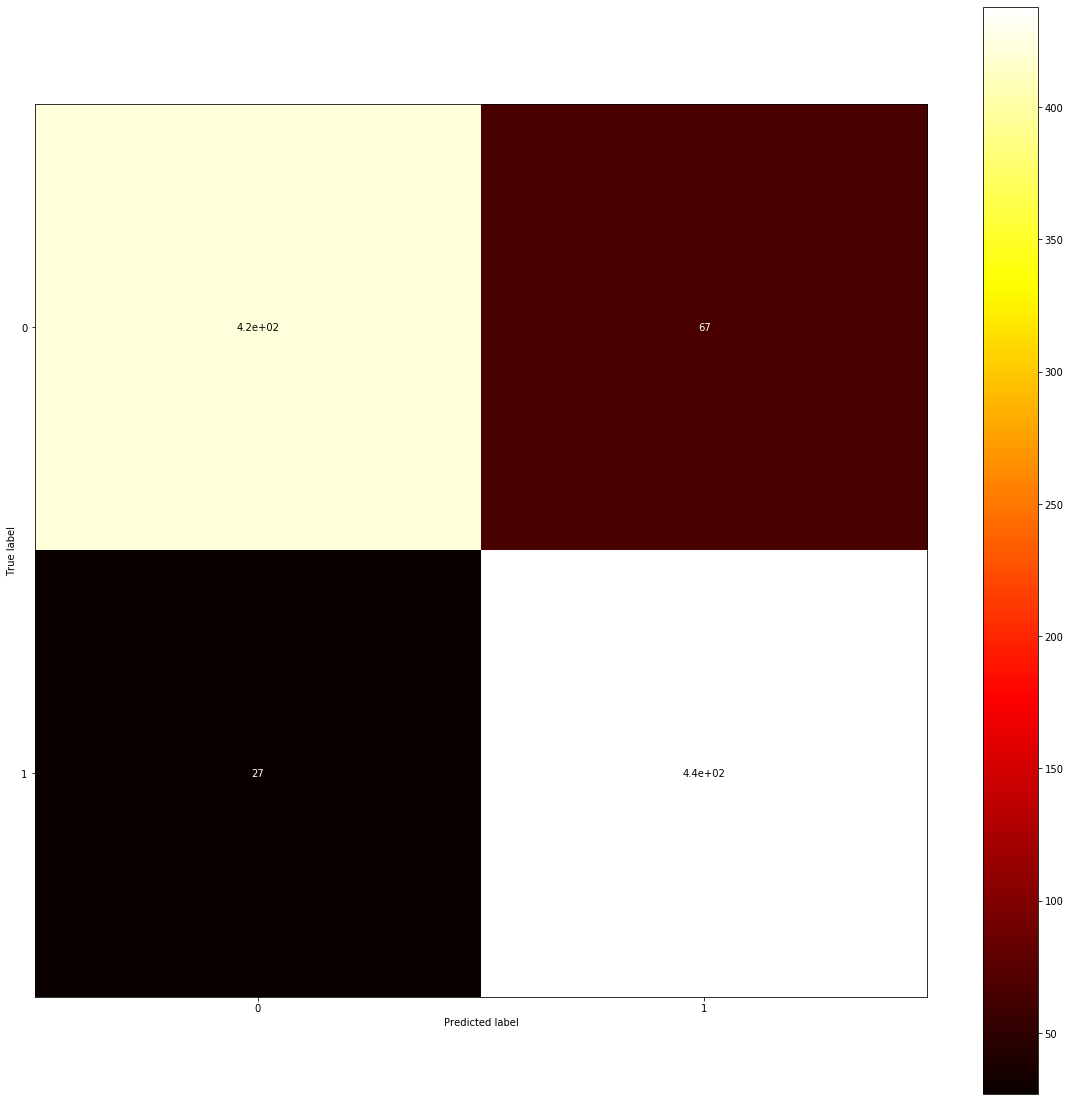

In [63]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

plot_confusion_matrix(pipeline, test1, labelsTest1, cmap='hot', ax=axes)